connect to pyspark

You have a problem to analyse using the data(some ML algo has to be used). And the data has sensitive information that cannot be given to the third party.

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
import pandas as pd
import numpy as np

In [2]:
spark

In [3]:
from pyspark.sql.functions import *
from pyspark.ml.classification import  RandomForestClassifier
from pyspark.ml.feature import StringIndexer, OneHotEncoderModel, OneHotEncoder, VectorAssembler, VectorSlicer
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.linalg import Vectors
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

In [4]:
df = spark.read.option("delimiter", ";").csv("bank-additional-full.csv", header=True, inferSchema = True)

In [5]:
df.dtypes

[('age', 'int'),
 ('job', 'string'),
 ('marital', 'string'),
 ('education', 'string'),
 ('default', 'string'),
 ('housing', 'string'),
 ('loan', 'string'),
 ('contact', 'string'),
 ('month', 'string'),
 ('day_of_week', 'string'),
 ('duration', 'int'),
 ('campaign', 'int'),
 ('pdays', 'int'),
 ('previous', 'int'),
 ('poutcome', 'string'),
 ('emp.var.rate', 'double'),
 ('cons.price.idx', 'double'),
 ('cons.conf.idx', 'double'),
 ('euribor3m', 'double'),
 ('nr.employed', 'double'),
 ('y', 'string')]

In [6]:
df = df.cache()

In [7]:
df = df.toDF(*(c.replace('.', '_') for c in df.columns)) # there is a issue if its .

In [8]:
df.limit(5).toPandas() # easy to visualise

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [9]:
stored_original = df.toPandas()

In [10]:
df.describe().toPandas()

,summary,age,job,marital,education,default,housing,loan,contact,month,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,count,41188,41188,41188,41188,41188,41188,41188,41188,41188,...,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
1,mean,40.02406040594348,None,None,None,None,None,None,None,None,...,2.567592502670681,962.4754540157328,0.17296299893172767,None,0.08188550063178392,93.57566436828918,-40.50260027191787,3.6212908128585366,5167.035910944004,None
2,stddev,10.421249980934057,None,None,None,None,None,None,None,None,...,2.770013542902331,186.9109073447414,0.49490107983928927,None,1.57095974051703,0.5788400489541355,4.628197856174595,1.7344474048512557,72.25152766825924,None
3,min,17,admin.,divorced,basic.4y,no,no,no,cellular,apr,...,1,0,0,failure,-3.4,92.201,-50.8,0.634,4963.6,no
4,max,98,unknown,unknown,unknown,yes,yes,yes,telephone,sep,...,56,999,7,success,1.4,94.767,-26.9,5.045,5228.1,yes


In [11]:
for i in df.dtypes:
    if i[1]=='string':
        print(df.groupBy(i[0]).count().orderBy('count', ascending=False).toPandas())

              job  count
0          admin.  10422
1     blue-collar   9254
2      technician   6743
3        services   3969
4      management   2924
5         retired   1720
6    entrepreneur   1456
7   self-employed   1421
8       housemaid   1060
9      unemployed   1014
10        student    875
11        unknown    330
    marital  count
0   married  24928
1    single  11568
2  divorced   4612
3   unknown     80
             education  count
0    university.degree  12168
1          high.school   9515
2             basic.9y   6045
3  professional.course   5243
4             basic.4y   4176
5             basic.6y   2292
6              unknown   1731
7           illiterate     18
   default  count
0       no  32588
1  unknown   8597
2      yes      3
   housing  count
0      yes  21576
1       no  18622
2  unknown    990
      loan  count
0       no  33950
1      yes   6248
2  unknown    990
     contact  count
0   cellular  26144
1  telephone  15044
  month  count
0   may  13769
1   

In [12]:
encoding_var = [i[0] for i in df.dtypes if (i[1]=='string') & (i[0]!='y')]
num_var = [i[0] for i in df.dtypes if ((i[1]=='int') | (i[1]=='double')) & (i[0]!='y')]

In [13]:
num_var

['age',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'emp_var_rate',
 'cons_price_idx',
 'cons_conf_idx',
 'euribor3m',
 'nr_employed']

In [14]:
df_num = df.select(*[col(x).cast('float') for x in num_var])

assembler = VectorAssembler(inputCols=num_var, outputCol = 'numerical_features')
df_corr_num = assembler.transform(df_num).select('numerical_features')

df_corr_num.take(2)

[Row(numerical_features=DenseVector([56.0, 261.0, 1.0, 999.0, 0.0, 1.1, 93.994, -36.4, 4.857, 5191.0])),
 Row(numerical_features=DenseVector([57.0, 149.0, 1.0, 999.0, 0.0, 1.1, 93.994, -36.4, 4.857, 5191.0]))]

In [15]:
from pyspark.ml.stat import Correlation

pearsonCorr = Correlation.corr(df_corr_num,'numerical_features','pearson').collect()[0][0]

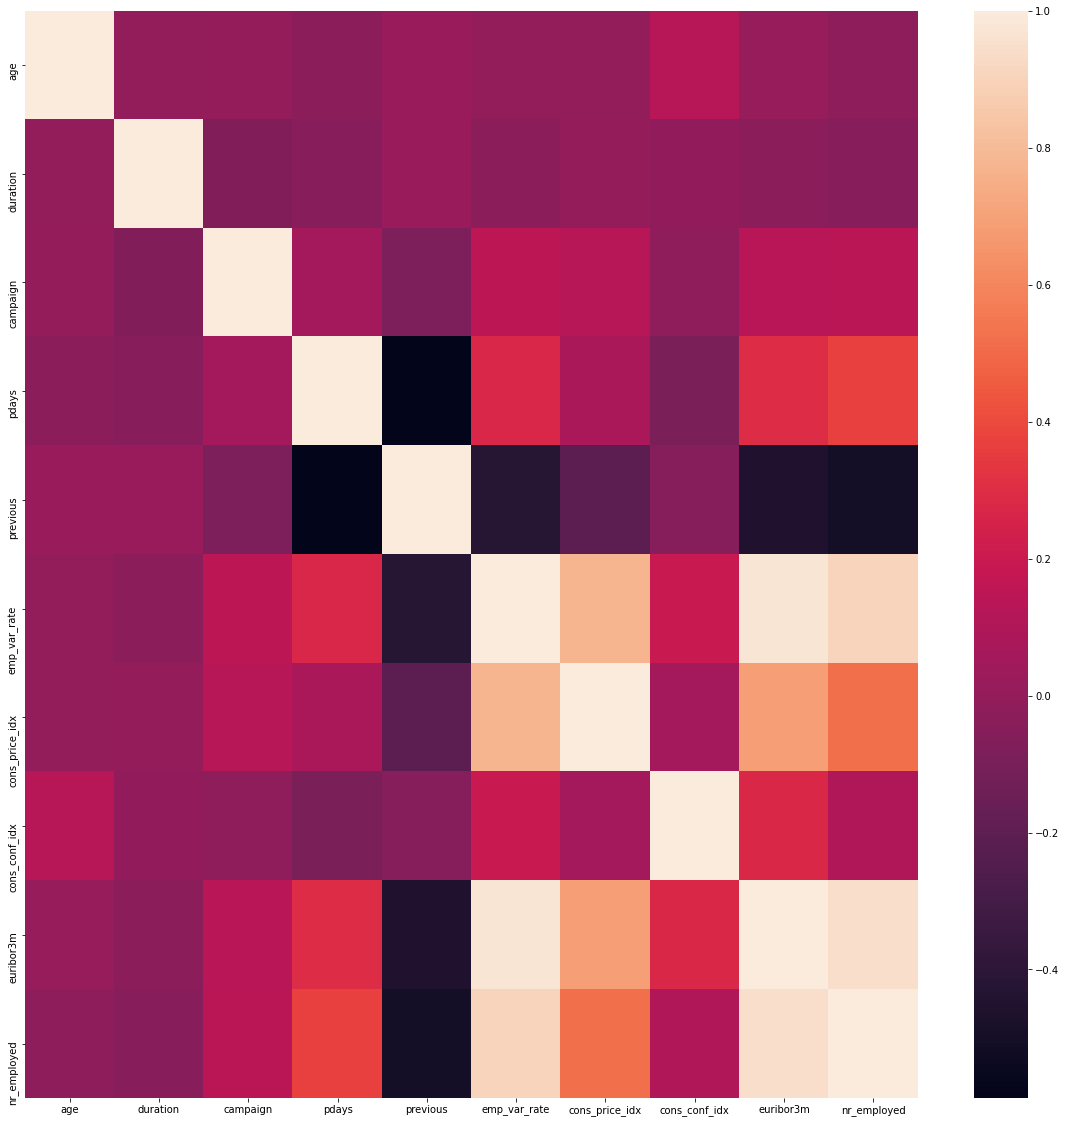

In [16]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

coor_df = pd.DataFrame(pearsonCorr.toArray(), index = num_var, columns = num_var)
plt.figure(figsize=(20,20))
sns.heatmap(coor_df)

In [95]:
highly_correlated_df = (coor_df.abs() > -0.3) & (coor_df.abs() < 0.3)

correlated_vars_index = (highly_correlated_df == True).any()
correlated_vars_names = correlated_vars_index[correlated_vars_index == True].index

de_duplicate = []

correlated_pairs = []

for i in correlated_vars_index.index:
    row = highly_correlated_df[i]
    de_duplicate.append(i)
    for j in correlated_vars_names:
        if j not in de_duplicate and row[j] == True:
            print(i,j,":",coor_df.loc[i,j])
            correlated_pairs.append((i,j))

age duration : -0.0008657050101409461
age campaign : 0.0045935804934133075
age pdays : -0.03436895116685874
age previous : 0.024364740936116586
age emp_var_rate : -0.00037068740481227216
age cons_price_idx : 0.000856829233271047
age cons_conf_idx : 0.12937162949679196
age euribor3m : 0.010767430297541345
age nr_employed : -0.017725178063711648
duration campaign : -0.07169922626415345
duration pdays : -0.04757701544561204
duration previous : 0.020640350701749105
duration emp_var_rate : -0.027967884230374725
duration cons_price_idx : 0.0053122999084147466
duration cons_conf_idx : -0.008172878081900248
duration euribor3m : -0.03289665612257271
duration nr_employed : -0.04470322124852558
campaign pdays : 0.052583573385031494
campaign previous : -0.07914147244884125
campaign emp_var_rate : 0.1507538051648242
campaign cons_price_idx : 0.12783582616714528
campaign cons_conf_idx : -0.013733100609290491
campaign euribor3m : 0.13513251130542064
campaign nr_employed : 0.14409501754684045
pdays em

In [18]:
print('num of num_features: ',len(num_var))

for pair in correlated_pairs :
    if pair[0] in num_var:
        num_var.remove(pair[0])
        
print('num of num_features after removing correlated ones: ',len(num_var))

num of num_features:  10
num of num_features after removing correlated ones:  8


In [19]:
num_var

['age',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'cons_price_idx',
 'cons_conf_idx',
 'nr_employed']

In [20]:
string_indexes = [StringIndexer(inputCol = c, outputCol = c +'/IDX', handleInvalid = 'keep') for c in encoding_var]
onehot_indexes = [OneHotEncoder(inputCols = [c +'/IDX'], outputCols = [c +'/OHE']) for c in encoding_var]
label_indexes = StringIndexer(inputCol = 'y', outputCol = 'label', handleInvalid = 'keep')
assembler = VectorAssembler(inputCols = num_var + [c +'/OHE' for c in encoding_var], outputCol = "features")
rf = RandomForestClassifier(labelCol="label", featuresCol="features", seed = 8464,
                            numTrees=10, cacheNodeIds = True, subsamplingRate = 0.7)

pipe = Pipeline(stages = string_indexes + onehot_indexes + [assembler, label_indexes, rf])

In [21]:
mod = pipe.fit(df)

In [22]:
df2 = mod.transform(df)

In [23]:
mod.stages[-1].featureImportances

SparseVector(61, {0: 0.0094, 1: 0.3126, 2: 0.0031, 3: 0.1715, 4: 0.0329, 5: 0.0655, 6: 0.0033, 7: 0.1738, 8: 0.0005, 10: 0.0002, 11: 0.0003, 12: 0.0006, 17: 0.0004, 18: 0.0003, 19: 0.0009, 21: 0.0002, 22: 0.0005, 25: 0.0009, 26: 0.0002, 27: 0.0002, 28: 0.0006, 30: 0.0007, 32: 0.0012, 33: 0.0004, 35: 0.0008, 36: 0.0005, 38: 0.0007, 40: 0.0003, 41: 0.0013, 42: 0.0152, 43: 0.0004, 44: 0.0004, 47: 0.0007, 48: 0.0043, 49: 0.0141, 50: 0.0002, 51: 0.0393, 52: 0.0007, 53: 0.0003, 54: 0.0033, 55: 0.0002, 57: 0.0006, 58: 0.0005, 59: 0.002, 60: 0.1338})

In [24]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

In [25]:
list_features = ExtractFeatureImp(mod.stages[-1].featureImportances, df2, "features")

select top 12 features

In [26]:
list_features

,idx,name,score
1,1,duration,0.312648
7,7,nr_employed,0.173784
3,3,pdays,0.171517
60,60,poutcome/OHE_success,0.133838
5,5,cons_price_idx,0.065494
...,...,...,...
37,37,housing/OHE_unknown,0.000000
46,46,month/OHE_jun,0.000000
45,45,month/OHE_aug,0.000000
39,39,loan/OHE_yes,0.000000


In [27]:
list_features = list_features[['name']]

In [28]:
selected_features = []

In [29]:
count = 0
for ind in list_features.index :
    feature = list_features['name'][ind]
    type(feature)
    if '/OHE' in feature:
        if feature.split('/')[0] in selected_features:
            pass
        else:
            selected_features.append(feature.split('/')[0])
            count = count + 1
    else :
        selected_features.append(feature)
        count = count + 1
    if( count == 12):                        # number of features selected
        break

In [30]:
selected_features.append('y')

ctgan 

In [31]:
selected_df = df.select([col for col in selected_features]).toPandas()

In [32]:
spark.stop()

In [33]:
selected_df

,duration,nr_employed,pdays,poutcome,cons_price_idx,month,previous,contact,age,day_of_week,cons_conf_idx,campaign,y
0,261,5191.0,999,nonexistent,93.994,may,0,telephone,56,mon,-36.4,1,no
1,149,5191.0,999,nonexistent,93.994,may,0,telephone,57,mon,-36.4,1,no
2,226,5191.0,999,nonexistent,93.994,may,0,telephone,37,mon,-36.4,1,no
3,151,5191.0,999,nonexistent,93.994,may,0,telephone,40,mon,-36.4,1,no
4,307,5191.0,999,nonexistent,93.994,may,0,telephone,56,mon,-36.4,1,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,334,4963.6,999,nonexistent,94.767,nov,0,cellular,73,fri,-50.8,1,yes
41184,383,4963.6,999,nonexistent,94.767,nov,0,cellular,46,fri,-50.8,1,no
41185,189,4963.6,999,nonexistent,94.767,nov,0,cellular,56,fri,-50.8,2,no
41186,442,4963.6,999,nonexistent,94.767,nov,0,cellular,44,fri,-50.8,1,yes


In [34]:
data = selected_df
#data = df.toPandas()

In [35]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   duration        41188 non-null  int32  
 1   nr_employed     41188 non-null  float64
 2   pdays           41188 non-null  int32  
 3   poutcome        41188 non-null  object 
 4   cons_price_idx  41188 non-null  float64
 5   month           41188 non-null  object 
 6   previous        41188 non-null  int32  
 7   contact         41188 non-null  object 
 8   age             41188 non-null  int32  
 9   day_of_week     41188 non-null  object 
 10  cons_conf_idx   41188 non-null  float64
 11  campaign        41188 non-null  int32  
 12  y               41188 non-null  object 
dtypes: float64(3), int32(5), object(5)
memory usage: 3.3+ MB
None


In [36]:
from sdv.tabular import CTGAN

model = CTGAN(cuda = True, verbose = True)
model.fit(data)

/home/ilan/.local/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0
/home/ilan/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/utils/validat

Epoch 1, Loss G:  0.4345,Loss D:  0.1520
Epoch 2, Loss G: -0.1437,Loss D: -0.0432
Epoch 3, Loss G: -0.6495,Loss D: -0.0148
Epoch 4, Loss G: -0.7111,Loss D:  0.1328
Epoch 5, Loss G: -0.5079,Loss D: -0.1324
Epoch 6, Loss G: -0.4691,Loss D: -0.1017
Epoch 7, Loss G: -0.3182,Loss D: -0.2853
Epoch 8, Loss G: -0.2172,Loss D: -0.4394
Epoch 9, Loss G:  0.3341,Loss D: -0.5487
Epoch 10, Loss G:  0.3102,Loss D: -0.3838
Epoch 11, Loss G: -0.1635,Loss D: -0.5282
Epoch 12, Loss G: -0.0315,Loss D: -0.2430
Epoch 13, Loss G: -0.0646,Loss D: -0.5097
Epoch 14, Loss G: -0.0634,Loss D: -0.3927
Epoch 15, Loss G: -0.1200,Loss D: -0.3872
Epoch 16, Loss G: -0.4090,Loss D: -0.6072
Epoch 17, Loss G: -0.2834,Loss D: -0.4174
Epoch 18, Loss G: -0.2712,Loss D: -0.4105
Epoch 19, Loss G: -0.2536,Loss D: -0.5694
Epoch 20, Loss G: -0.4552,Loss D: -0.5318
Epoch 21, Loss G: -0.5509,Loss D: -0.3003
Epoch 22, Loss G: -0.5141,Loss D: -0.3004
Epoch 23, Loss G: -0.3787,Loss D: -0.2822
Epoch 24, Loss G: -0.1980,Loss D: -0.2487
E

Epoch 195, Loss G: -0.3328,Loss D: -0.2377
Epoch 196, Loss G: -0.2036,Loss D: -0.2922
Epoch 197, Loss G: -0.0432,Loss D: -0.2191
Epoch 198, Loss G: -0.1376,Loss D: -0.4135
Epoch 199, Loss G: -0.2565,Loss D: -0.1163
Epoch 200, Loss G: -0.2296,Loss D: -0.1716
Epoch 201, Loss G: -0.0464,Loss D: -0.2080
Epoch 202, Loss G: -0.0240,Loss D: -0.1909
Epoch 203, Loss G:  0.0022,Loss D: -0.3198
Epoch 204, Loss G: -0.0889,Loss D: -0.2355
Epoch 205, Loss G: -0.3743,Loss D: -0.1772
Epoch 206, Loss G: -0.2669,Loss D:  0.0374
Epoch 207, Loss G: -0.3212,Loss D: -0.2780
Epoch 208, Loss G:  0.0892,Loss D: -0.2915
Epoch 209, Loss G: -0.1331,Loss D: -0.1273
Epoch 210, Loss G: -0.1309,Loss D: -0.3192
Epoch 211, Loss G: -0.2928,Loss D: -0.3056
Epoch 212, Loss G: -0.2327,Loss D: -0.2802
Epoch 213, Loss G: -0.3564,Loss D: -0.2674
Epoch 214, Loss G: -0.0629,Loss D: -0.3905
Epoch 215, Loss G:  0.0050,Loss D: -0.3361
Epoch 216, Loss G: -0.0584,Loss D: -0.2352
Epoch 217, Loss G: -0.1410,Loss D: -0.3140
Epoch 218, 

In [37]:
syn_data = model.sample(41188)
syn_data.head(20)

,duration,nr_employed,pdays,poutcome,cons_price_idx,month,previous,contact,age,day_of_week,cons_conf_idx,campaign,y
0,221,5228.206334,998,nonexistent,94.465717,jun,0,telephone,27,fri,-41.849892,4,no
1,664,5021.442960,16,success,92.628603,dec,0,cellular,55,fri,-33.218518,1,yes
2,368,5228.166430,998,nonexistent,94.464303,nov,0,telephone,53,thu,-41.907378,0,no
3,138,5099.097871,999,failure,92.912430,may,1,cellular,67,fri,-46.541842,1,no
4,638,5228.008988,999,nonexistent,93.916406,jul,0,cellular,32,thu,-42.683658,1,yes
5,242,4957.009635,4,success,94.097122,oct,2,cellular,53,wed,-49.698614,1,no
6,231,5023.227495,999,failure,92.647858,dec,0,cellular,25,fri,-33.225311,1,no
7,341,5075.271730,999,nonexistent,92.930280,jul,0,cellular,27,thu,-40.613520,2,yes
8,128,5228.219539,998,nonexistent,94.458536,jun,0,telephone,56,fri,-41.839518,0,no
9,247,5228.572762,999,nonexistent,93.442791,aug,0,cellular,47,fri,-36.005178,6,no


(41188, 13) (41188, 13)


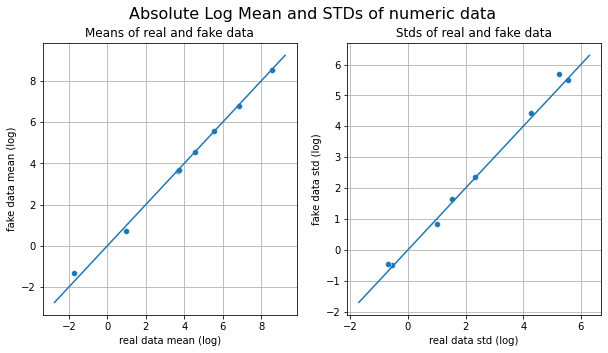

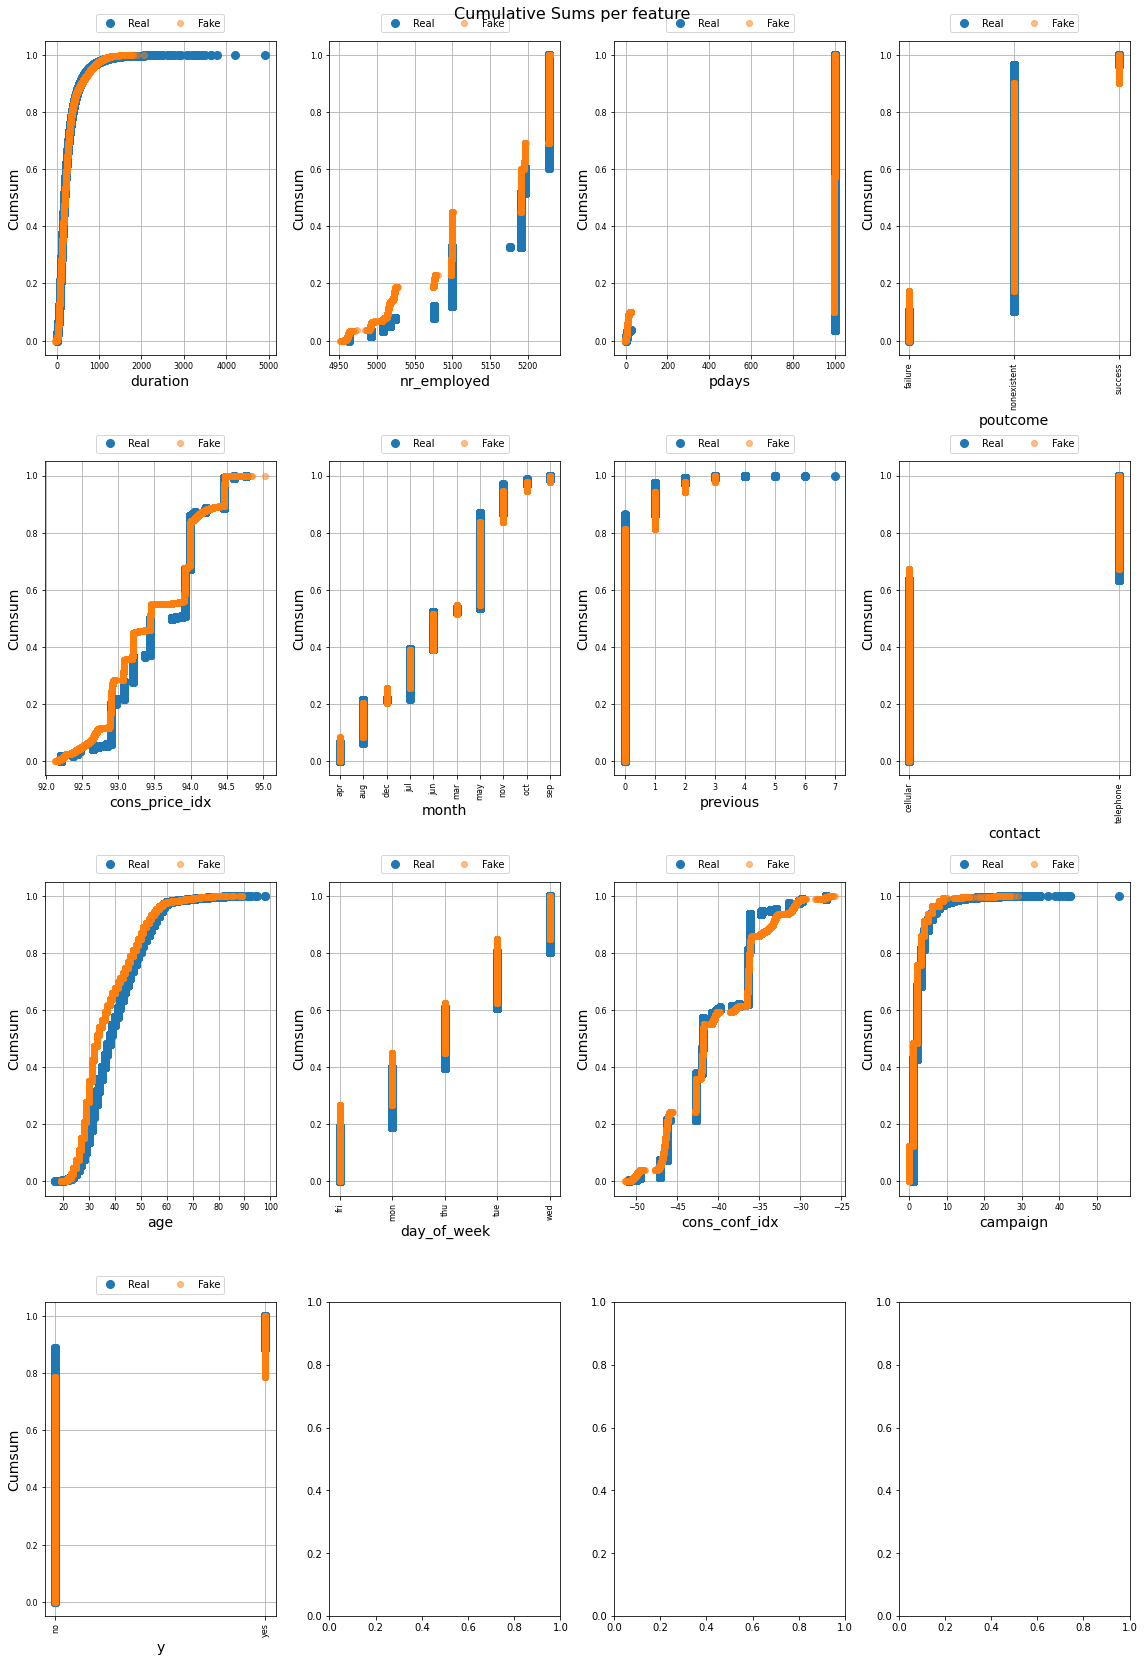

/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ilan/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an

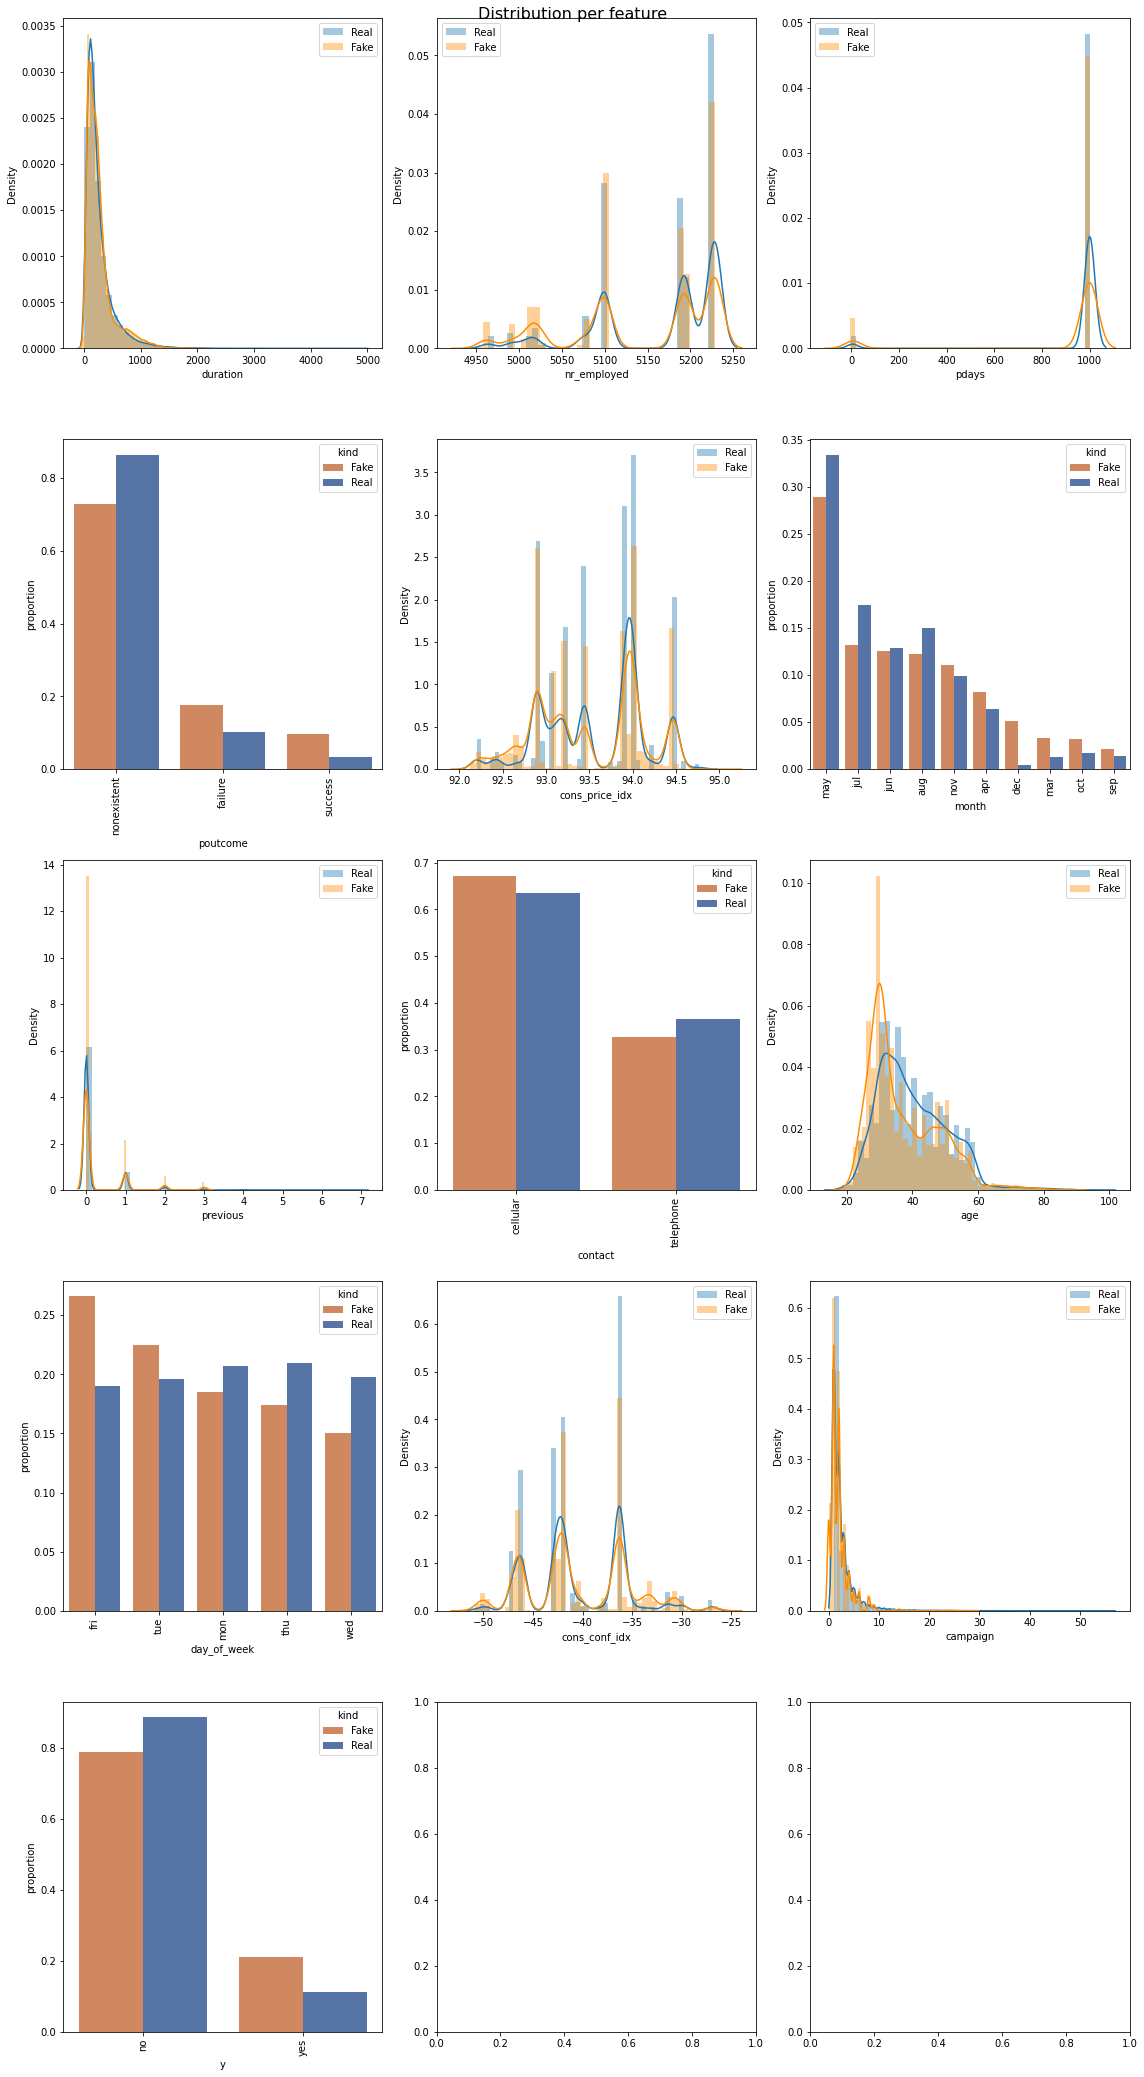

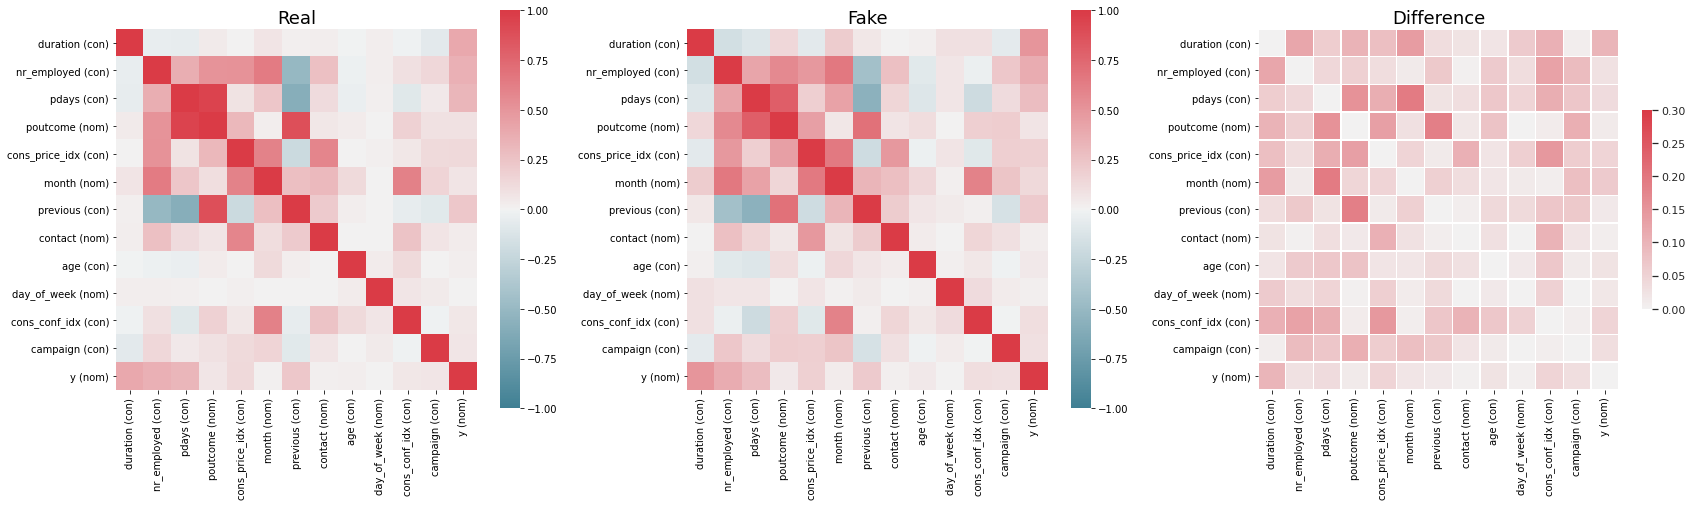

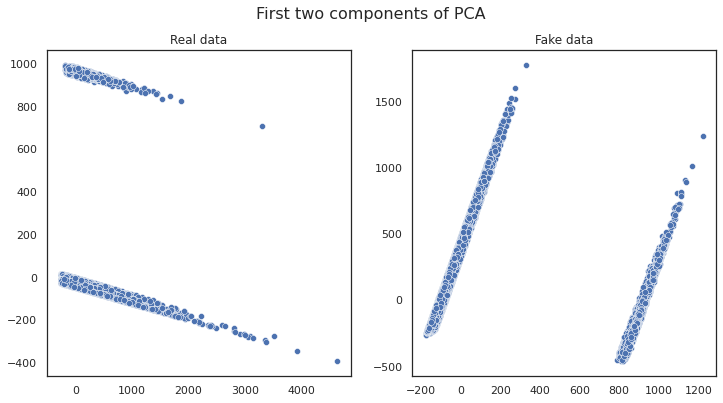

In [38]:
from table_evaluator import load_data, TableEvaluator

print(data.shape, syn_data.shape)
table_evaluator =  TableEvaluator(data, syn_data)

table_evaluator.visual_evaluation()

model likelihood tests

In [39]:
from sdv.metrics.tabular import CSTest, KSTest

CSTest.compute(data, syn_data)

0.919955950085126

In [40]:
KSTest.compute(data, syn_data)

0.8172283189278431

ML efficacy

In [41]:
from sdv.metrics.tabular import BinaryDecisionTreeClassifier

BinaryDecisionTreeClassifier.compute(data,syn_data, target='y')

0.9209599637962976

Detection test  output = 1 - (ROC AUC)  ;    (ROC AUC)  0.5 < 1.0  = good classification
                our output = 0.64     ;  (ROC AUC) = 1 - 0.64 = 0.36  => bad classification
                
Bad classification not able to classify between syn_data and real_data

In [42]:
from sdv.metrics.tabular import LogisticDetection

LogisticDetection.compute(data, syn_data)

/home/ilan/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/ilan/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logist

0.6251915601651978

In [43]:
syn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   duration        41188 non-null  int32  
 1   nr_employed     41188 non-null  float64
 2   pdays           41188 non-null  int32  
 3   poutcome        41188 non-null  object 
 4   cons_price_idx  41188 non-null  float64
 5   month           41188 non-null  object 
 6   previous        41188 non-null  int32  
 7   contact         41188 non-null  object 
 8   age             41188 non-null  int32  
 9   day_of_week     41188 non-null  object 
 10  cons_conf_idx   41188 non-null  float64
 11  campaign        41188 non-null  int32  
 12  y               41188 non-null  object 
dtypes: float64(3), int32(5), object(5)
memory usage: 3.3+ MB


In [44]:
# Python code t get difference of two lists
# Using set()
def Diff(li1, li2):
    return list(set(li1) - set(li2)) + list(set(li2) - set(li1))

num_cols_syn_data = syn_data.select_dtypes(include=['float64','int32'])

In [45]:
num_cols_syn_data.columns.tolist()

['duration',
 'nr_employed',
 'pdays',
 'cons_price_idx',
 'previous',
 'age',
 'cons_conf_idx',
 'campaign']

In [46]:
l = ['emp_var_rate', 'euribor3m']

In [47]:
num_var = ['age',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'emp_var_rate',
 'cons_price_idx',
 'cons_conf_idx',
 'euribor3m',
 'nr_employed']

In [74]:
stored_original.head(10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
5,45,services,married,basic.9y,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
6,59,admin.,married,professional.course,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
7,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
8,24,technician,single,professional.course,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
9,25,services,single,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [85]:
test1 = pd.DataFrame(stored_original, columns=num_var)

In [86]:
part1 = pd.DataFrame(syn_data, columns=num_cols_syn_data.columns.tolist())
part1.head(10)

,duration,nr_employed,pdays,cons_price_idx,previous,age,cons_conf_idx,campaign
0,221,5228.206334,998,94.465717,0,27,-41.849892,4
1,664,5021.442960,16,92.628603,0,55,-33.218518,1
2,368,5228.166430,998,94.464303,0,53,-41.907378,0
3,138,5099.097871,999,92.912430,1,67,-46.541842,1
4,638,5228.008988,999,93.916406,0,32,-42.683658,1
5,242,4957.009635,4,94.097122,2,53,-49.698614,1
6,231,5023.227495,999,92.647858,0,25,-33.225311,1
7,341,5075.271730,999,92.930280,0,27,-40.613520,2
8,128,5228.219539,998,94.458536,0,56,-41.839518,0
9,247,5228.572762,999,93.442791,0,47,-36.005178,6


In [87]:
part2 = pd.DataFrame(stored_original, columns=l)
part2.head(10)

,emp_var_rate,euribor3m
0,1.1,4.857
1,1.1,4.857
2,1.1,4.857
3,1.1,4.857
4,1.1,4.857
5,1.1,4.857
6,1.1,4.857
7,1.1,4.857
8,1.1,4.857
9,1.1,4.857


In [88]:
test_merged = pd.concat([part1, part2], axis=1)
test_merged.head(10)

,duration,nr_employed,pdays,cons_price_idx,previous,age,cons_conf_idx,campaign,emp_var_rate,euribor3m
0,221,5228.206334,998,94.465717,0,27,-41.849892,4,1.1,4.857
1,664,5021.442960,16,92.628603,0,55,-33.218518,1,1.1,4.857
2,368,5228.166430,998,94.464303,0,53,-41.907378,0,1.1,4.857
3,138,5099.097871,999,92.912430,1,67,-46.541842,1,1.1,4.857
4,638,5228.008988,999,93.916406,0,32,-42.683658,1,1.1,4.857
5,242,4957.009635,4,94.097122,2,53,-49.698614,1,1.1,4.857
6,231,5023.227495,999,92.647858,0,25,-33.225311,1,1.1,4.857
7,341,5075.271730,999,92.930280,0,27,-40.613520,2,1.1,4.857
8,128,5228.219539,998,94.458536,0,56,-41.839518,0,1.1,4.857
9,247,5228.572762,999,93.442791,0,47,-36.005178,6,1.1,4.857


In [89]:
test_merged = pd.DataFrame(test_merged, columns=num_var)

In [90]:
test1.head(5)

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0


In [91]:
test_merged.head(5)

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
0,27,221,4,998,0,1.1,94.465717,-41.849892,4.857,5228.206334
1,55,664,1,16,0,1.1,92.628603,-33.218518,4.857,5021.442960
2,53,368,0,998,0,1.1,94.464303,-41.907378,4.857,5228.166430
3,67,138,1,999,1,1.1,92.912430,-46.541842,4.857,5099.097871
4,32,638,1,999,0,1.1,93.916406,-42.683658,4.857,5228.008988


In [92]:
test1.corr(method ='pearson')

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
age,1.000000,-0.000866,0.004594,-0.034369,0.024365,-0.000371,0.000857,0.129372,0.010767,-0.017725
duration,-0.000866,1.000000,-0.071699,-0.047577,0.020640,-0.027968,0.005312,-0.008173,-0.032897,-0.044703
campaign,0.004594,-0.071699,1.000000,0.052584,-0.079141,0.150754,0.127836,-0.013733,0.135133,0.144095
pdays,-0.034369,-0.047577,0.052584,1.000000,-0.587514,0.271004,0.078889,-0.091342,0.296899,0.372605
previous,0.024365,0.020640,-0.079141,-0.587514,1.000000,-0.420489,-0.203130,-0.050936,-0.454494,-0.501333
emp_var_rate,-0.000371,-0.027968,0.150754,0.271004,-0.420489,1.000000,0.775334,0.196041,0.972245,0.906970
cons_price_idx,0.000857,0.005312,0.127836,0.078889,-0.203130,0.775334,1.000000,0.058986,0.688230,0.522034
cons_conf_idx,0.129372,-0.008173,-0.013733,-0.091342,-0.050936,0.196041,0.058986,1.000000,0.277686,0.100513
euribor3m,0.010767,-0.032897,0.135133,0.296899,-0.454494,0.972245,0.688230,0.277686,1.000000,0.945154
nr_employed,-0.017725,-0.044703,0.144095,0.372605,-0.501333,0.906970,0.522034,0.100513,0.945154,1.000000


In [93]:
test_merged.corr(method ='pearson')

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
age,1.000000,0.021918,-0.008252,-0.103017,0.066463,-0.003954,-0.020458,0.060782,-0.004386,-0.082788
duration,0.021918,1.000000,-0.063309,-0.106229,0.055585,-0.008091,-0.076842,0.098048,-0.007865,-0.167337
campaign,-0.008252,-0.063309,1.000000,0.123997,-0.146575,-0.000524,0.187633,-0.004624,-0.000154,0.231750
pdays,-0.103017,-0.106229,0.123997,1.000000,-0.562213,-0.006195,0.191245,-0.202788,-0.008488,0.416296
previous,0.066463,0.055585,-0.146575,-0.562213,1.000000,0.001097,-0.190173,0.020663,0.002529,-0.434983
emp_var_rate,-0.003954,-0.008091,-0.000524,-0.006195,0.001097,1.000000,-0.002443,-0.000994,0.972245,0.002710
cons_price_idx,-0.020458,-0.076842,0.187633,0.191245,-0.190173,-0.002443,1.000000,-0.086958,-0.001599,0.488931
cons_conf_idx,0.060782,0.098048,-0.004624,-0.202788,0.020663,-0.000994,-0.086958,1.000000,-0.001476,-0.028418
euribor3m,-0.004386,-0.007865,-0.000154,-0.008488,0.002529,0.972245,-0.001599,-0.001476,1.000000,0.002591
nr_employed,-0.082788,-0.167337,0.231750,0.416296,-0.434983,0.002710,0.488931,-0.028418,0.002591,1.000000


In [94]:
spark.stop()